<a href="https://colab.research.google.com/github/m3rkul0v/PyTorchModel/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
'''
Откроем наш csv-файл и загрузим данные в датафрейм, используя в качестве разделителя " ; "
'''
df = pd.read_csv('meatinfo.csv', sep = ';')
df

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17888,"Ягнятина, шея, бк",Ягнятина
17889,Язык ягненка (н.зеландия) Отварные языки ягнят...,Ягнятина
17890,"Ягнятина, язык, зачищ. цена 100 руб.",Ягнятина
17891,"Як, задние части, 1 категория цена 550 руб.",Як


In [ ]:
'''
Выберем только те данные, которые требуются по ТЗ -
брать только виды продукции, для которых в датасете есть не менее 500 примеров
'''
s = df['mtype']
a = list(df['mtype'].value_counts().index[df['mtype'].value_counts() >= 500])
print(*a)


Говядина Свинина Кура Индейка Баранина Цыпленок


In [ ]:
df_clean = df[(df['mtype']=='Говядина') | (df['mtype']=='Свинина') | (df['mtype']=='Кура') | (df['mtype']=='Индейка') | (df['mtype']=='Баранина') | (df['mtype']=='Цыпленок')]

<Axes: xlabel='mtype', ylabel='count'>

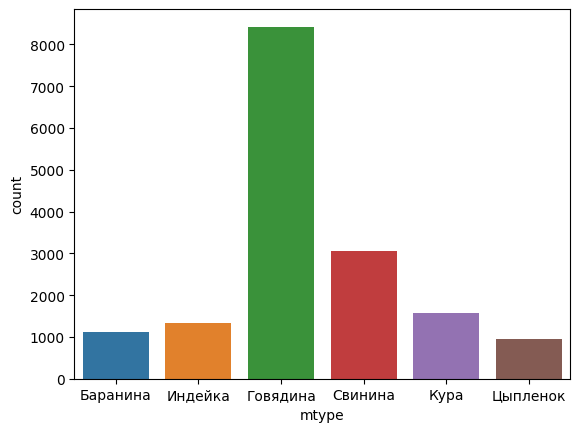

In [ ]:
sns.countplot(x = 'mtype', data=df_clean)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
unique_mtype = df_clean['mtype'].unique()
mtype_dict = {mtype: i for i, mtype in enumerate(unique_mtype)}
print(mtype_dict)
df_clean['mtype'] = df_clean['mtype'].replace(mtype_dict)

{'Баранина': 0, 'Индейка': 1, 'Говядина': 2, 'Свинина': 3, 'Кура': 4, 'Цыпленок': 5}


<ipython-input-8-9d9f2050f42f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['mtype'] = df_clean['mtype'].replace(mtype_dict)


In [ ]:
print(df_clean['mtype'][1])

0


In [ ]:
text = df_clean['text'].tolist()
mtype = df_clean['mtype'].tolist()

In [ ]:
import re
for i in range(len(text)):
  text[i] = re.sub(r'[^\w\s]', '', text[i])

print(text[1])

Баранина 12 частей зам цена 260 руб


In [ ]:
tokenized_text = [word_tokenize(t) for t in text]



In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(tokens) for tokens in tokenized_text])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, mtype, test_size=0.2, random_state=42)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_dataset = TextDataset(X_train.toarray(), y_train)
test_dataset = TextDataset(X_test.toarray(), y_test)

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
input_dim = X.shape[1]
num_classes = 6
hidden_dim = 12
output_dim = num_classes
learning_rate = 0.03
num_epochs = 20
batch_size = 6

In [ ]:
model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs, labels.long())
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print('epoch: {} loss: {:.4f}'.format(epoch+1, total_loss/len(train_loader)))

epoch: 1 loss: 1.1211
epoch: 2 loss: 1.0876
epoch: 3 loss: 1.0823
epoch: 4 loss: 1.0817
epoch: 5 loss: 1.0805
epoch: 6 loss: 1.0812
epoch: 7 loss: 1.0787
epoch: 8 loss: 1.0769
epoch: 9 loss: 1.0747
epoch: 10 loss: 1.0736
epoch: 11 loss: 1.0713
epoch: 12 loss: 1.0735
epoch: 13 loss: 1.0741
epoch: 14 loss: 1.0781
epoch: 15 loss: 1.0724
epoch: 16 loss: 1.0715
epoch: 17 loss: 1.0711
epoch: 18 loss: 1.0715
epoch: 19 loss: 1.0697
epoch: 20 loss: 1.0692


In [ ]:
model.eval()
predicted_labels=[]
acc = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels += predicted.tolist()
for i in range(len(predicted_labels)):
  if predicted_labels[i] == y_test[i]:
      acc+=1

print('Accuracy:', acc/len(predicted_labels))

Accuracy: 0.9367396593673966


In [ ]:
new_text = 'Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.'

tokens = nltk.word_tokenize(new_text)


new_features = vectorizer.transform([' '.join(tokens)]).toarray()


new_tensor = torch.tensor(new_features).view(1, -1)


with torch.no_grad():
  output = model(new_tensor.float())
  predicted_class_idx = torch.argmax(output).item()


predicted_class = list(mtype_dict.keys())[predicted_class_idx]
print(predicted_class)

NameError: ignored

In [ ]:
new_text = 'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел'

tokens = nltk.word_tokenize(new_text)


new_features = vectorizer.transform([' '.join(tokens)]).toarray()


new_tensor = torch.tensor(new_features).view(1, -1)


with torch.no_grad():
  output = model(new_tensor.float())
  predicted_class_idx = torch.argmax(output).item()


predicted_class = list(mtype_dict.keys())[predicted_class_idx]
print(predicted_class)

Кура


In [ ]:
new_text = 'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'

tokens = nltk.word_tokenize(new_text)


new_features = vectorizer.transform([' '.join(tokens)]).toarray()


new_tensor = torch.tensor(new_features).view(1, -1)


with torch.no_grad():
  output = model(new_tensor.float())
  predicted_class_idx = torch.argmax(output).item()


predicted_class = list(mtype_dict.keys())[predicted_class_idx]
print(predicted_class)

Говядина
